In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import string
import re
import nltk
import emoji
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sodjs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sodjs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [3]:
df = pd.read_csv('C:/Users/sodjs/RL/data/sentimentdataset.csv')
df.head(2)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8


In [4]:
df.duplicated().sum()

np.int64(0)

In [5]:
df1 = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags', 'Day', 'Hour'])
df1['Timestamp'] = pd.to_datetime(df['Timestamp'])
df1['Sentiment'] = df1['Sentiment'].str.lower().str.strip()
df1.head(2)

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1


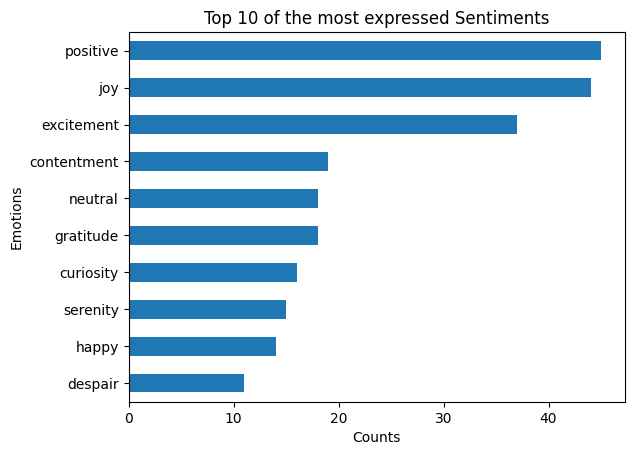

In [6]:
df1['Sentiment'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 of the most expressed Sentiments')
plt.xlabel('Counts')
plt.ylabel('Emotions')
plt.show()

In [7]:
df1['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [8]:
#plt.figure(figsize=(12, 6))
#sns.countplot(x='Year', hue= , data=df1)

In [9]:
def process1_text(text):
    "Remove url, punctuations, stopwords"
    url_removed = re.sub(r'http\S+|www\S+', '', text)
    punc_removed = url_removed.translate(str.maketrans('', '', string.punctuation))
    split_words = punc_removed.split()
    filtered_word = [word for word in split_words if word.lower() not in stopwords_eng]
    return ' '.join(filtered_word)

def demojize_text(text):
    "demoji, lemmatize text"
    return emoji.demojize(text)
 
df1['Text'] = df1['Text'].apply(process1_text)
df1['Text'] = df1['Text'].apply(demojize_text)
df1.head()

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month
0,Enjoying beautiful day park,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1
1,Traffic terrible morning,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1
2,finished amazing workout :flexed_biceps:,positive,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1
3,Excited upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1
4,Trying new recipe dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1


In [10]:
def pos_tag_convert(nltk_tag: str)->str:
    "Used for Lemmatization"
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
df1['Text_Lem'] = df1['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos_tag_convert(word)) for word in x.split()]))
df1.head()

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Text_Lem
0,Enjoying beautiful day park,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Enjoying beautiful day park
1,Traffic terrible morning,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Traffic terrible morning
2,finished amazing workout :flexed_biceps:,positive,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,finished amazing workout :flexed_biceps:
3,Excited upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1,Excited upcoming weekend getaway
4,Trying new recipe dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1,Trying new recipe dinner tonight


In [12]:
df2 = df1.drop(columns=['Timestamp', 'User', 'Platform', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Text'])
df2.head()

,Sentiment,Text_Lem
0,positive,Enjoying beautiful day park
1,negative,Traffic terrible morning
2,positive,finished amazing workout :flexed_biceps:
3,positive,Excited upcoming weekend getaway
4,neutral,Trying new recipe dinner tonight


In [13]:
sentiment_encoded = pd.get_dummies(df2['Sentiment'])
fin_df = pd.concat([df2['Text_Lem'], sentiment_encoded], axis=1)

print("Number of columns:", len(fin_df.columns))
print("List of sentiment columns:", list(sentiment_encoded.columns))
fin_df.head()

Number of columns: 192
List of sentiment columns: ['acceptance', 'accomplishment', 'admiration', 'adoration', 'adrenaline', 'adventure', 'affection', 'amazement', 'ambivalence', 'amusement', 'anger', 'anticipation', 'anxiety', 'appreciation', 'apprehensive', 'arousal', 'artisticburst', 'awe', 'bad', 'betrayal', 'bitter', 'bitterness', 'bittersweet', 'blessed', 'boredom', 'breakthrough', 'calmness', 'captivation', 'celebration', 'celestial wonder', 'challenge', 'charm', 'colorful', 'compassion', 'compassionate', 'confidence', 'confident', 'confusion', 'connection', 'contemplation', 'contentment', 'coziness', 'creative inspiration', 'creativity', 'culinary adventure', 'culinaryodyssey', 'curiosity', 'darkness', 'dazzle', 'desolation', 'despair', 'desperation', 'determination', 'devastated', 'disappointed', 'disappointment', 'disgust', 'dismissive', 'dreamchaser', 'ecstasy', 'elation', 'elegance', 'embarrassed', 'emotion', 'emotionalstorm', 'empathetic', 'empowerment', 'enchantment', 'ene

,Text_Lem,acceptance,accomplishment,admiration,adoration,adrenaline,adventure,affection,amazement,ambivalence,...,tranquility,triumph,vibrancy,whimsy,whispers of the past,winter magic,wonder,wonderment,yearning,zest
0,Enjoying beautiful day park,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Traffic terrible morning,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,finished amazing workout :flexed_biceps:,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Excited upcoming weekend getaway,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Trying new recipe dinner tonight,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
y = sentiment_encoded.values
positive_indices = y[:, list(sentiment_encoded.columns).index('positive')].astype(int)
X = df2['Text_Lem'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=30)

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, 
    positive_indices, 
    test_size=0.2, 
    random_state=42,
    stratify=positive_indices
)
print("distribution in training set:")
print(pd.Series(y_train).value_counts())

distribution in training set:
0    549
1     36
Name: count, dtype: int64


In [35]:
model = Sequential([
    Embedding(5000, 100),
    BatchNormalization(),
    
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
total = len(y_train)
class_weight = {
    0: total / (2 * neg_count),
    1: total / (2 * pos_count)
}

print("Class weights:", class_weight)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Class weights: {0: np.float64(0.5327868852459017), 1: np.float64(8.125)}


In [36]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'\nTrain accuracy: {train_acc*100:.2f}%')
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5108 - loss: 0.7534 - val_accuracy: 0.8974 - val_loss: 0.6761
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6007 - loss: 0.4647 - val_accuracy: 0.9060 - val_loss: 0.6279
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6411 - loss: 0.4310 - val_accuracy: 0.9060 - val_loss: 0.5739
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6950 - loss: 0.3596 - val_accuracy: 0.9060 - val_loss: 0.5148
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7239 - loss: 0.3105 - val_accuracy: 0.9060 - val_loss: 0.4697
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7776 - loss: 0.2770 - val_accuracy: 0.9060 - val_loss: 0.4286
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8112 - loss: 0.2538 - val_accuracy: 0.9060 - val_loss: 0.3991
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8670 - loss: 0.2074 - val_accuracy: 0.9060 - v

In [37]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, pred_binary))
print("\nClassification Report: ")
print(classification_report(y_test, pred_binary))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step

Confusion Matrix: 
[[138   0]
 [  9   0]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       138
           1       0.00      0.00      0.00         9

    accuracy                           0.94       147
   macro avg       0.47      0.50      0.48       147
weighted avg       0.88      0.94      0.91       147



c:\Users\sodjs\RL\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sodjs\RL\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sodjs\RL\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


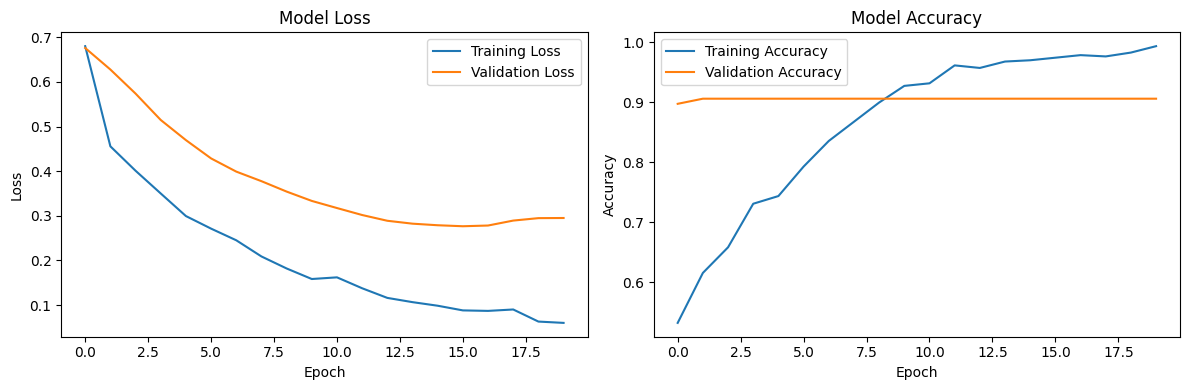

In [38]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
y = sentiment_encoded.values
sentiment_sums = pd.Series(y.sum(axis=0), index=sentiment_encoded.columns)
top_10_sentiments = sentiment_sums.nlargest(10).index
y_filtered = y[:, [list(sentiment_encoded.columns).index(sent) for sent in top_10_sentiments]]

max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df2['Text_Lem'])

X = tokenizer.texts_to_sequences(df2['Text_Lem'])

max_length = 50

X_pad = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

print("Original number of categories:", y.shape[1])
print("Filtered number of categories:", y_filtered.shape[1])
print("\nTop 10 sentiments:")
for sent, count in sentiment_sums.nlargest(10).items():
    print(f"{sent}: {count}")

Original number of categories: 191
Filtered number of categories: 10

Top 10 sentiments:
positive: 45
joy: 44
excitement: 37
contentment: 19
gratitude: 18
neutral: 18
curiosity: 16
serenity: 15
happy: 14
despair: 11


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered.argmax(axis=1))

model = Sequential([
    Embedding(max_words, 300, input_length=max_length),
    Dropout(0.2),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='sigmoid')
])

c:\Users\sodjs\RL\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.1244 - loss: 0.6697 - val_accuracy: 0.0085 - val_loss: 0.3048 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.0918 - loss: 0.2627 - val_accuracy: 0.0085 - val_loss: 0.1919 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2020 - loss: 0.1933 - val_accuracy: 0.7009 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2602 - loss: 0.1718 - val_accuracy: 0.7009 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2792 - loss: 0.1746 - val_accuracy: 0.0940 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1839 - loss: 0.1607 - val_accuracy: 0.0940 - val_loss: 0.1591 - learning_rate: 0.0010
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1851 - loss: 0.1626 - val_acc

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7293 - loss: 0.1365 

Test accuracy: 73.47%


In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7293 - loss: 0.1365 

Test accuracy: 73.47%


In [22]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


In [23]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

for i, sentiment in enumerate(top_10_sentiments):
    print(f"\n{sentiment}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test[:, i], pred_binary[:, i]))
    print("\nClassification Report:")
    print(classification_report(y_test[:, i], pred_binary[:, i], zero_division=0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

positive:
Confusion Matrix:
[[141   0]
 [  6   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       141
        True       0.00      0.00      0.00         6

    accuracy                           0.96       147
   macro avg       0.48      0.50      0.49       147
weighted avg       0.92      0.96      0.94       147


joy:
Confusion Matrix:
[[138   0]
 [  9   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       138
        True       0.00      0.00      0.00         9

    accuracy                           0.94       147
   macro avg       0.47      0.50      0.48       147
weighted avg       0.88      0.94      0.91       147


excitement:
Confusion Matrix:
[[140   0]
 [  7   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.95     

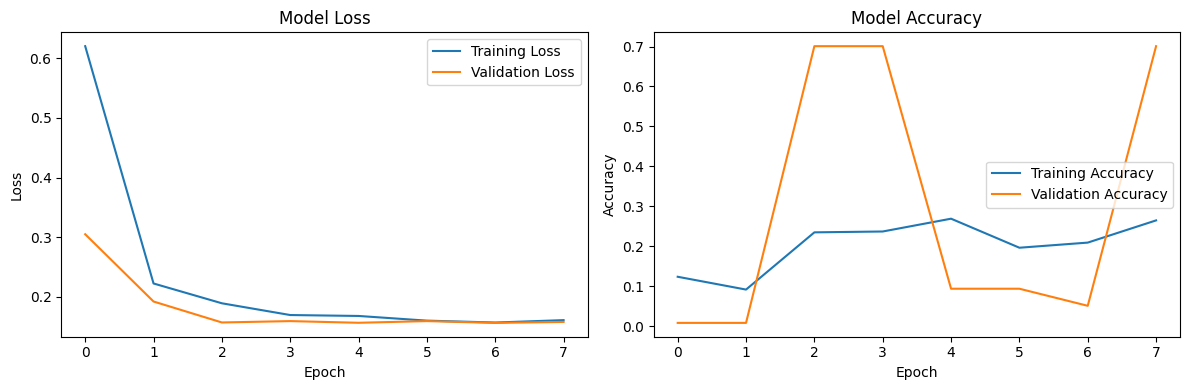

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Caveat**

Since there is a Class Imbalance problem, it causes the lower accuracy for training.
e.g.
Top 10 sentiments:
positive: 45
joy: 44
excitement: 37
contentment: 19
gratitude: 18
neutral: 18
curiosity: 16
serenity: 15
happy: 14
despair: 11
